# Project: Ukrainian coffee market segments


#### Abstract
Coffee has become an integral part of our everyday lives. We start the day with it, have one with friends/colleagues over a break, and even go on coffee dates. It's not surprising that almost any establishment has a variety available 24/7. Why is it so? 

The answer is pretty simple - it brings a lot of money. To illustrate the impact of coffee on our daily life, let's look at some numbers. In 2020/2021 the total coffee consumption worldwide had been estimated to be 166.63 million 60kg bags [1]. Moreover, within five years, the market is estimated to bring $201.4 billion [2]. It makes sense why coffee stands are popping up on every corner, doesn't it? 


#### Introduction

The analysis was conducted to understand the current coffee market in Ukraine. This information would then be used to create marketing plans to expand the businesses. To understand the market, we were supplemented with a dataset consisting of 200 entries that were evenly spread across 10 regions. It's also important to mention that, even though there are ten cities, the number of unique regions is nine. There are two cities, Khrivoy Rog and Dnipro, that represent the same Dnipropetrovsk region. 

This notebook discusses the methods that were used for data cleaning, exploratory data analysis, feature and model selection. Since the end-goal was to find the segments, there was a need to select an appropriate unsupervised algortihm. The dataset had more categorical values than numeric, there were two algrotihms implemented: K-Means and K-Prototype. To facilitate a smooth comprehension of the steps and findings to people of both technical and non-technical backgrounds, each code block explains the tools being used as well as the findings of using them.  


### Table of Content

* [Dataset](#dataset)
* [Data Cleaning](#clean)
* [Exploratory Data Analysis](#explore)
    * Q1: [What's the most common shop in each region?](#q1) 
    * Q2: [Do trends differ depending on the city's size?](#q2)
    * Q3: [Do rating/review ratio change with services provided?](#q3)
* [Model Selection](#eval)
* [Results & Interpretations](#results)
* [Final Recommendations](#recommend)

---

### Dataset <a class="anchor" id="dataset"/>

---

The analysis was conducted to understand the current coffee market in Ukraine. This information would then be used to create marketing plans to expand the business nationally. To understand the market, we were supplemented with a dataset that was made of 200 data entries that were evenly spread across 10 regions.

| Column | Description |
| --- | --- | 
| Region | One of 10 possible regions where coffee shops are located |
| Place name | Name of the shop |
| Place type | Type of coffee shop (e.g., "Cafe", "Espresso Bar", ...) |
| Rating | Coffe shop rating (on a 5 point scale) |
| Reviews | Number of reviews provided for the shop | 
| Price | Price category (\\$, \\$\\$, \\$\\$\\$) | 
| Delivery option | True/False, describing whether there is or isn't a delivery option | 
| Dine in option | True/False, describing whether there is or isn't a dine-in option | 
| Takeout option | True/False, describing whether there is or isn't a takeout option |


#### 💡 Insights

- Each region represent a unique county (oblast) except for Khrivoy Rog and Dnipro, both of which belong to Dnipropetrovsk oblast. Therefore, there are officially 9 unique regions present.  
- The regions can be divided into the three categories depending on their population which ranges from 280,000 (Poltava) to almost 3,000,000 (Kiev). The categories are: metropolis, city, and county. 


In [2]:
# run this cell to install additional packages
# !pip install kmodes
# !pip install ppscore 
# !pip install plotly
# !pip install missingno

In [3]:
# import essential packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ppscore as pps
import missingno as msno

import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from kmodes.kprototypes import KPrototypes

from utils import viz

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# set visualization parameters
plt.rcParams["figure.figsize"] = (10, 5)
sns.set()
sns.set_palette('dark')

In [4]:
# read data and show the first data values
shops = pd.read_csv('data/coffee_shops.csv')
shops.head(3)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,NaN,True


In [5]:
# check dataset's shape
print('Dataset shape:', shops.shape)

# check the number of missing values
missing = shops[shops.isna().any(axis=1)]
print(f'Number of rows with missing values: {len(missing)} ({(len(missing) / len(shops)) * 100}%)')

# check where the data is missing
print('\n')
shops.info()

Dataset shape: (200, 9)
Number of rows with missing values: 121 (60.5%)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   140 non-null    object 
 8   Takeout option   144 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


In [6]:
# count how many instances in each region
shops.groupby('Region').agg({'Place type': 'count'}).rename(columns={'Place type': 'Region count'})

,Region count
Region,
Dnipro,20
Kharkiv,20
Kherson,20
Khrivoy Rog,20
Kiev,20
Lviv,20
Mariupol,20
Odessa,20
Poltava,20


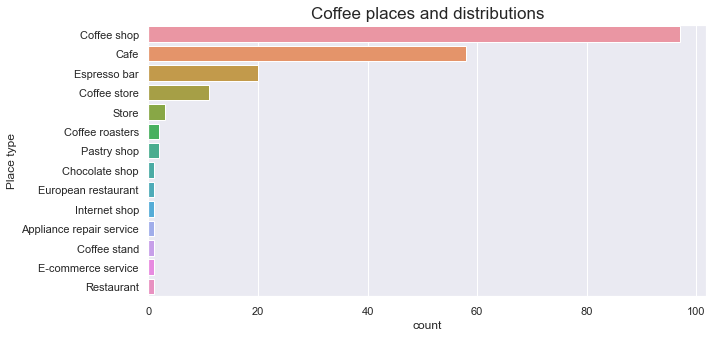

In [7]:
# show unique venues' distributions
sns.countplot(data=shops, y='Place type', 
              order=shops['Place type'].value_counts().index)

# set title and show
plt.title('Coffee places and distributions', fontsize=17)
plt.show()

#### 📝 Summary

From just a small number of code blocks we can see some important information:
- There are 10 regions each of which has 20 records. The dataset is evenly distributed. 
- 60% of the total data entries have at least one missing value. The majority of them fall into the last four columns: price, delivery, dine-in, and takeout options. Do they have a common pattern? Do reviews, ratings, and prices differ for the services? That's what we will investigate next. 
- Almost 50% of the dataset is comprised of coffee shops. The second plot reveals that 8 out of 10 regions have more coffee shops than any other venue. The two regions, Khrivoy Rog and Dnipro seem to have a bigger number of cafes. 

Since the missing value situation is pretty serious, we need to carefully investigate each column and choose an appropriate imputation (filling in the missing values) tool. However, before we start doing so, it's quite important to see the outlier situation because it can introduce errors into the dataset. Therefore, the next step is going to target the outlier situation. 

---

### Data Cleaning  <a class="anchor" id="clean"/>

---

This part consists of a series of steps that involve looking into the missing value condition, finding patterns, imputing and putting the entries into the same format. The process will follow the following format:

* [Understand the nature of missing values](#understand)
* [Deal with missing values](#missing)
* [Deal with outliers](#outliers)
* [Deal with duplicates](#duplicates)

#### Understand the nature of missing values  <a class="anchor" id="understand"/>

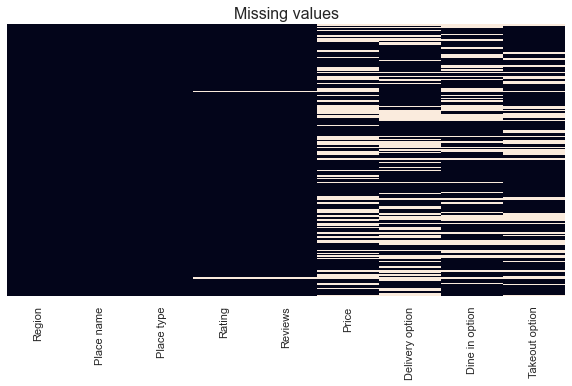

In [8]:
# look into the distribution of missing values
viz.missing_vals(shops)

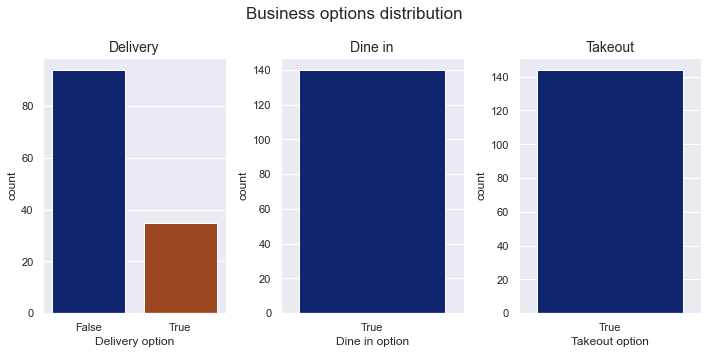

In [9]:
# look into the last three columns and
# see if there is a pattern in missing values
fig, ax = plt.subplots(1, 3)
fig.suptitle('Business options distribution', fontsize=17)
sns.countplot(shops['Delivery option'], ax=ax[0])
sns.countplot(shops['Dine in option'], ax=ax[1])
sns.countplot(shops['Takeout option'], ax=ax[2])

# set titles
ax[0].set_title('Delivery', fontsize=14)
ax[1].set_title('Dine in', fontsize=14)
ax[2].set_title('Takeout', fontsize=14)

# fix formatting and show the plot
plt.tight_layout()
plt.show()

#### 💡 Insight 

The side-by-side barplots show that the last two columns have only one recurring value. This raises a question, "Can we simply impute the rest of the data entries with False?". The answer is no. There are two main reasons for that:
- It can introduce the venues that don't provide any services: no delivery, no dine-in or takeout options. This would be a pretty useless business, wouldn't it? 
- There is a pattern for the missing values! 

A closer look into the place types showed that there was a mixture of cafes, stores, e-shops, and coffe-places. This means that such places as e-shops and repair shops introduced the necessity to include "takeout" column (other places are required to have such an option). After careful consideration, I have narrowed down the imputation process into the following steps:
 
- Cafes and restaurants **must** have both dine-in and takeout options
- E-shops and appliance/convenience/service stores **cannot** have any of the options because they can sell a lot of other things at the same time. Here we have two options: drop the values or put them onto the same category "Other". 
- All places **except** for e-shops and service shops should have a takeout option 



#### Deal with missing values <a class="anchor" id="missing"/>

##### Fix delivery column

In [10]:
# get columns that need to have delivery option
places = ['Store', 'Appliance repair service', 'E-commerce service']
cols = shops.columns[-3:]

# get indices of entries with no delivery 
idx = shops[(shops[cols[0]] == False) & 
            (shops[cols[1]] == False) & 
            (shops[cols[2]] == False) &
            (~shops['Place type'].isin(places))].index

# enable delivery
shops.loc[idx, 'Delivery option'] = True

##### Cafes & Restaurants

In [11]:
# select place types 
dinein_venues = ['Cafe', 'Restaurant', 'European restaurant']

# get indices of venues with missing or disabled dine-in options
dinein = shops[(shops['Place type'].isin(dinein_venues)) & 
               ((shops['Dine in option'] == False) | 
                (shops['Dine in option'].isna()) | 
                (shops['Takeout option'] == False) |
                (shops['Takeout option'].isna()))]

print(f'Number of data entries: {len(dinein)}')
dinein.head(3)

Number of data entries: 20


,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
23,Poltava,Coffee House,Cafe,4.7,329.0,$$,False,NaN,True
25,Poltava,Your Coffee,Cafe,4.7,569.0,$$,False,True,NaN


In [12]:
# set last two columns to true 
shops.loc[dinein.index, ['Dine in option', 'Takeout option']] = True

# verify the changes
assert len(shops[(shops['Place type'].isin(dinein_venues)) & 
                 ((shops['Dine in option'] == False) | 
                  (shops['Dine in option'].isna()))]) == 0

##### E-commerce services and Internet shops

In [13]:
# select the columns to disable
cols = ['Delivery option', 'Dine in option', 'Takeout option']

# select place types that should have options disabled
other = ['Internet shop', 'Appliance repair service', 'Store', 'E-commerce service']

# define a function to change the option types
change_type = lambda x: 'Other' if x in other else x 

# fill in the values
eshops = shops[shops['Place type'].isin(other)].index 
shops.loc[eshops, cols] = False 
shops['Place type'] = shops['Place type'].apply(lambda x: change_type(x))

# verify the changes
shops.loc[eshops]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
61,Zaporozhye,Art Coffee - Інтернет Магазин Кави та Чаю,Other,5.0,12.0,NaN,False,False,False
63,Zaporozhye,"Мастерская ""Кофе на разлив""",Other,5.0,15.0,NaN,False,False,False
68,Zaporozhye,Coffee House,Other,4.7,132.0,NaN,False,False,False
82,Odessa,Кофе База Одесса | Coffee Baza,Other,5.0,10.0,NaN,False,False,False
141,Kiev,"""®КАВА БАЗА®""",Other,5.0,21.0,NaN,False,False,False
181,Dnipro,Dim Kavy,Other,4.9,39.0,NaN,False,False,False


##### Takeout option

In [14]:
# enable takeout option for everything except for "Other"
idx = shops[~shops['Place type'].isin(['Other'])].index
shops.loc[idx, 'Takeout option'] = True 

##### Dine in option

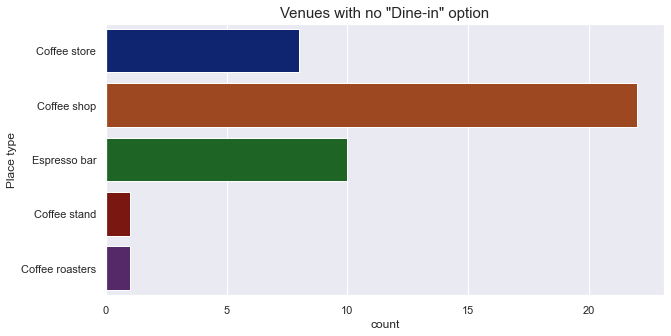

In [15]:
# select venues with missing Dine-in option
no_dinein = shops[shops['Dine in option'].isna()]

# visualize the distributions
plt.title('Venues with no "Dine-in" option', fontsize=15)
sns.countplot(data=no_dinein, y='Place type')
plt.show()

The venues and their distributions make sense to not have a "Dine-in" option, therefore it's safe to fill in the missing values with False. 


In [16]:
# fill in the missing values 
shops.loc[no_dinein.index, 'Dine in option'] = False

##### Delivery option

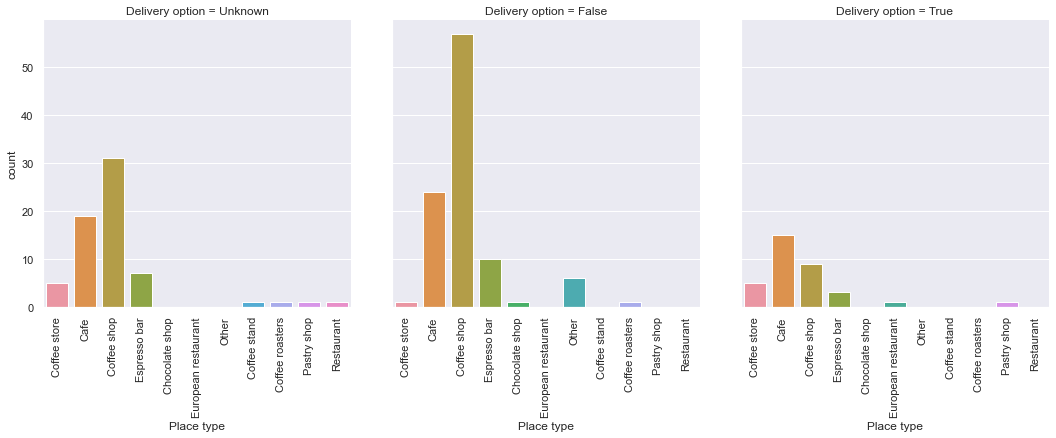

In [17]:
# fill in the delivery option with "Unknown"
no_delivery = shops[shops['Delivery option'].isna()].index
shops.loc[no_delivery, 'Delivery option'] = 'Unknown'

# display the distributions
g = sns.catplot(data=shops, x='Place type', col='Delivery option', kind='count')
g.set_xticklabels(rotation=90)
plt.show()

In [18]:
# verify there are no "all false" options except for "Other" place types
shops[(shops['Dine in option'] == False) & 
      (shops['Delivery option'] == False) & 
      (shops['Takeout option'] == False)]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
61,Zaporozhye,Art Coffee - Інтернет Магазин Кави та Чаю,Other,5.0,12.0,NaN,False,False,False
63,Zaporozhye,"Мастерская ""Кофе на разлив""",Other,5.0,15.0,NaN,False,False,False
68,Zaporozhye,Coffee House,Other,4.7,132.0,NaN,False,False,False
82,Odessa,Кофе База Одесса | Coffee Baza,Other,5.0,10.0,NaN,False,False,False
141,Kiev,"""®КАВА БАЗА®""",Other,5.0,21.0,NaN,False,False,False
181,Dnipro,Dim Kavy,Other,4.9,39.0,NaN,False,False,False


In [19]:
# verify there are no cafes and restaurants with disabled dine-in option
shops[(shops['Place type'].isin(['Cafe', 'Restaurant'])) & (shops['Dine in option'] == False)]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option


We see above that the "Reviews" column has a kurtosis score of almost 120 which is bad. Let's investigate the data points and decide what to do with them next. 

##### Price, Rating, and Reviews columns

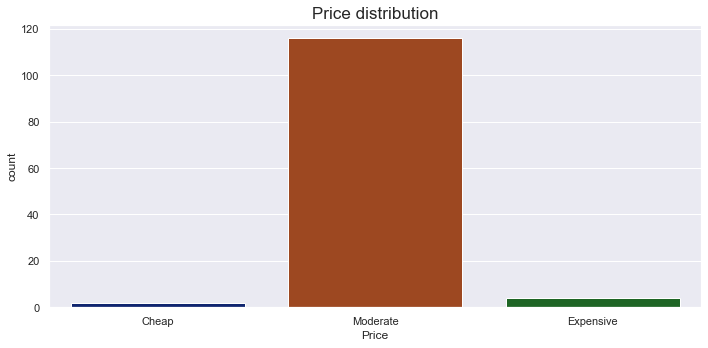

In [20]:
# create a map to have better visualization
mapping = {'$': 'Cheap', '$$': 'Moderate', '$$$': 'Expensive'}

# construct a countplot
sns.countplot(x=shops['Price'].replace(mapping).dropna(),
              order=['Cheap', 'Moderate', 'Expensive'])

# set title and show
plt.title('Price distribution', fontsize=17)
plt.tight_layout()
plt.show()

In [21]:
# fill in the missing values
shops['Price'].fillna('$$', inplace=True)

In [22]:
# get a dictionary for ratings and reviews columns
ratings_mean = shops.groupby('Place type')['Rating'].mean().to_dict()
reviews_median = shops.groupby('Place type')['Reviews'].median().to_dict()

In [23]:
# fix the missing values
shops.loc[49, 'Rating'] = round(ratings_mean['Cafe'], 2)
shops.loc[49, 'Reviews'] = reviews_median['Cafe']

shops.loc[186, 'Rating'] = round(ratings_mean['Coffee shop'], 2)
shops.loc[186, 'Reviews'] = reviews_median['Coffee shop']

In [24]:
# verify there are no missing values
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           200 non-null    float64
 4   Reviews          200 non-null    float64
 5   Price            200 non-null    object 
 6   Delivery option  200 non-null    object 
 7   Dine in option   200 non-null    object 
 8   Takeout option   200 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


#### Deal with outliers <a class="anchor" id="outliers"/>

One of the best tools to check the outlier condition is by checking the curtosis score. It's essentially a tool that lets you see how far the tails are using a normal distribution. It's acceptable to have curtosis score in the range of -3 and 3. 


Curtosis score
Rating              1.096487
Reviews           120.469577
Dine in option     -0.500109
Takeout option     29.116958
dtype: float64


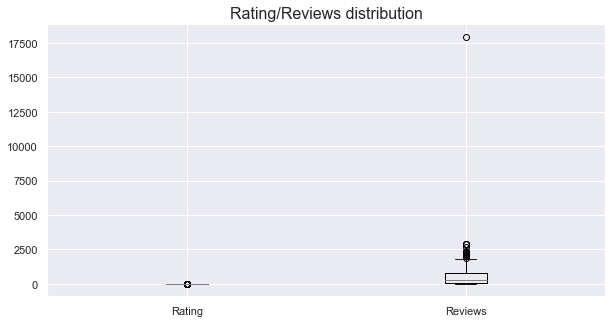

In [25]:
# calculate curtosis score
print('Curtosis score')
print(shops.kurtosis())

# show a boxplot representation of the numeric columns
shops.boxplot().set_title('Rating/Reviews distribution', fontsize=16)
plt.show()

In [26]:
# check the entries that are 3 standard deviations away from the mean
shops[shops['Reviews'] > shops['Reviews'].std() * 3]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
100,Lviv,Lviv Coffee Manufacture,Coffee shop,4.7,17937.0,$$,True,True,True


In [27]:
# drop the outlier
shops.drop(index=100, axis='rows', inplace=True)

# reset the indices such that there's no gap
shops.reset_index(drop=True)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,Unknown,False,True
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,True,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,Unknown,False,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,$$,Unknown,True,True
...,...,...,...,...,...,...,...,...,...
194,Dnipro,Artist,Restaurant,4.6,963.0,$$$,Unknown,True,True
195,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True
196,Dnipro,РУТА КАФЕ ПП КУЛІЧЕНКО К.І.,Cafe,4.6,16.0,$$,False,True,True
197,Dnipro,Ob'yektna Kava,Coffee shop,4.7,599.0,$$,Unknown,True,True


#### Potential duplicates <a class="anchor" id="duplicates"/>

It's always a good practice to check the dataset for duplicates. We see that there are 187 unique place names. However, can there be duplicates just because the names are written in ALL CAPS or have everything in lower case? Let's look into that! 

In [28]:
# show the number of unique place names
print('Number of unique place names before cleaning', len(shops['Place name'].unique()))

# put every place name into the same format
shops['Place name'] = shops['Place name'].apply(lambda x: x.title())

# show the cleaned unique place names
print('Number of unique place names after cleaning', len(shops['Place name'].unique()))

Number of unique place names before cleaning 187
Number of unique place names after cleaning 183


#### Finishing touches

One last thing to do is to fix categories. Why is it important? Doing so saves a lot of space. It's always a good practice to do so. That's why let's keep the standards even with 200 entries!

In [29]:
# select categorical data
numeric = shops.select_dtypes([np.number]).columns.tolist()
columns = shops.columns.tolist()

# set the types accordingly
cat = list(set(columns).difference(set(numeric)))
shops[cat] = shops[cat].astype('category')

# verify changes
shops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Region           199 non-null    category
 1   Place name       199 non-null    category
 2   Place type       199 non-null    category
 3   Rating           199 non-null    float64 
 4   Reviews          199 non-null    float64 
 5   Price            199 non-null    category
 6   Delivery option  199 non-null    category
 7   Dine in option   199 non-null    category
 8   Takeout option   199 non-null    category
dtypes: category(7), float64(2)
memory usage: 13.0 KB


---

### Exploratory data analysis <a class="anchor" id="explore"/>

---

After having the dataset properly cleaned, it was time to explore it. To have a better understanding, I wanted to answer the following questions:

- **What's the most common shop in each region?** 
- **Do trends differ depending on the city's size?** 
- **Do rating/review ratio change with services provided?**


##### First step
To see how data is related to each other, we typically use Correlation Matrix. However, our case requires something more powerful. Since Correlation Matrix can only work with numeric data, we need a tool that can reveal some insights about the categorical values! Therefore, I'm using a <a href="https://github.com/8080labs/ppscore">Power Score Matrix</a> instead. It's much more powerful in many ways, so we will stick to it. Now hidden data can no longer hide! If we see that some columns are way too correlated, we will drop them. It's never a good idea to have column duplicates.

**💡 Insights**: <br>

- "Takeout option" and "Place type" have the perfect correlation. It will only hurt the dataset if we leave it as is. Therefore, we will drop the "Takeout option" column. 
- "Dine-in option" and "Place type" have some interesting relationship. We will need to take a look at it. 
- Even without the code, we have previously seen that 8/10 regions had more coffee shops. This trend can be seen in the relationship between "Place type" and "Region" 

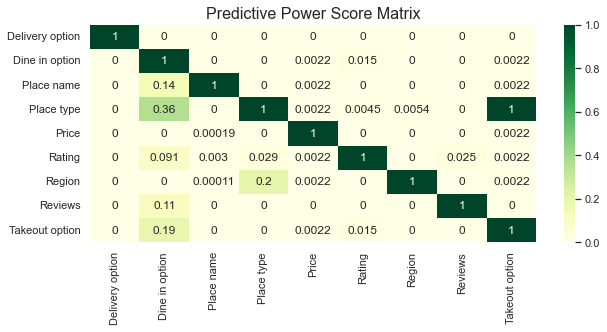

In [30]:
# get correlations
viz.pps_matrix(shops)

In [31]:
# drop the column
shops.drop('Takeout option', axis='columns', inplace=True)

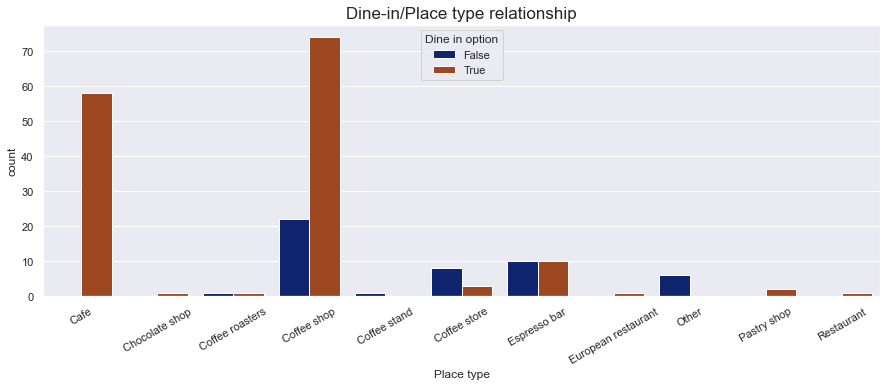

In [32]:
# look at "Dine-in option" and "Place type" rel
plt.figure(figsize=(15, 5))
sns.countplot(data=shops, x='Place type', hue='Dine in option')

# set title & axis
plt.title('Dine-in/Place type relationship', fontsize=17)
plt.xticks(rotation=30)
plt.show()

### Question 1: What's the most common place in each region? <a class="anchor" id="q1"/>

To answer this question, we will need to group the dataset by regions and find the most common place type. 


In [33]:
# show most common places
places = shops.groupby('Region')['Place type'].value_counts().rename('count').\
               reset_index().groupby('Region').first()

# add ratio
places['ratio'] = round(places['count'] / 20, 2)

# show 
places.rename(columns={'level_1': 'Place type'}).sort_values('count', ascending=False)

,Place type,count,ratio
Region,,,
Khrivoy Rog,Cafe,15,0.75
Kharkiv,Coffee shop,14,0.70
Lviv,Coffee shop,14,0.70
Odessa,Coffee shop,14,0.70
Dnipro,Cafe,12,0.60
Kherson,Coffee shop,12,0.60
Mariupol,Coffee shop,11,0.55
Poltava,Coffee shop,10,0.50
Kiev,Coffee shop,8,0.40


#### 💡 Insights: Coffee shops vs Cafes

- Only 2 out of 14 place types are most common in each region.
- 8 out of 10 cities have a much bigger number of Coffee shops. 
- Both cities with cafes on the lead come from the same region (Khrivoy Rog & Dnipro).
- The biggest cities with population over a million (Kharkiv & Odessa) generally have a much bigger number of coffee shops. 
- The capital, Kiev, still has coffee shops on the lead but in much smaller quantity. This needs to be explored further!

### Question 2: Do big cities have different trends than the smaller ones? <a class="anchor" id="q2"/>

To answer the second question, we need to do some googling to see the cities' populations and create the appropriate divisions. As it turned out, the dataset can be nicely divided into three:
- Metropolis = population over 1,000,000
- City = population over 300,000 and less than 1,000,000
- County = population less than 300,000


| Region | Population | Divison
| --- | --- | --- |
| Kyiv (Kiev) | 2,962,180 | Metropolis | 
| Kharkiv | 1,433,886 | Metropolis | 
| Odessa | 1,015,826 | Metropolis |
| Dnipro | 980,948 | City | 
| Zaporozhye | 722,713 | City | 
| Lviv | 721,510 | NaN | City |
| Khrivoy Rog | 612,750 | City | 
| Mariupol | 431,859 | City | 
| Kherson | 283,649 | County | 
| Poltava | 283,402 | County | 

In [34]:
# create the mapping to separate megapolis, city, and counties
def mapping(x):
    if x in ['Kiev', 'Kharkiv', 'Odessa']:
        return 'Metropolis'
    if x in ['Kherson', 'Poltava']:
        return 'County'
    return 'City'


# map data 
shops['Division'] = shops['Region'].apply(lambda x: mapping(x))
shops.head(3)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Division
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,Unknown,False,City
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,True,City
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,Unknown,False,City


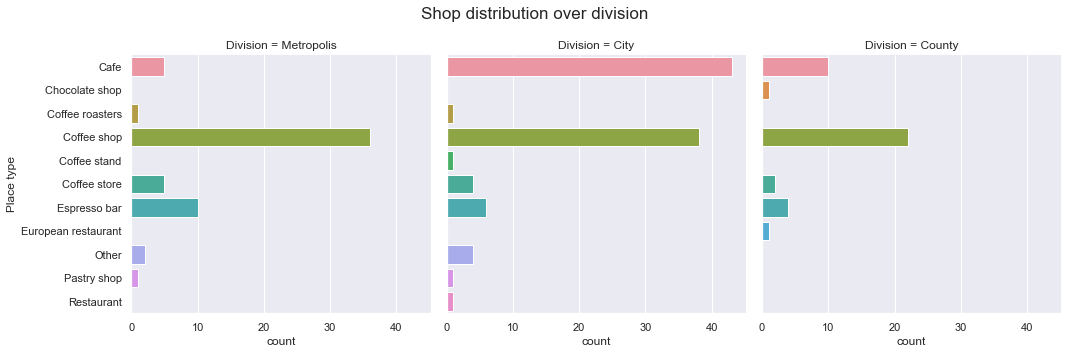

In [35]:
# show place type distribution on division
g = sns.catplot(data=shops, y='Place type', 
            kind='count', col='Division', 
            col_order=['Metropolis', 'City', 'County'])

# set title & layouts
g.fig.suptitle('Shop distribution over division', fontsize=17)
plt.tight_layout()
plt.show()

#### 💡 Insights: Coffee shops vs Cafes

- Divisions have different trends
While both biggest and smallest cities somewhat share the same characteristics, the medium-sized regions have cafes on the lead. As seen above, coffee shops are not that far away! 
- The capital, Kiev, which has population of almost 3 million, has a rich variety of shops that would satisfy the needs of different people. Here coffee shops are still on the lead, but there's also a big number of Espresso bars and other places. 

### Question 3: Do rating/review ratio change with services provided? <a class="anchor" id="q3"/>

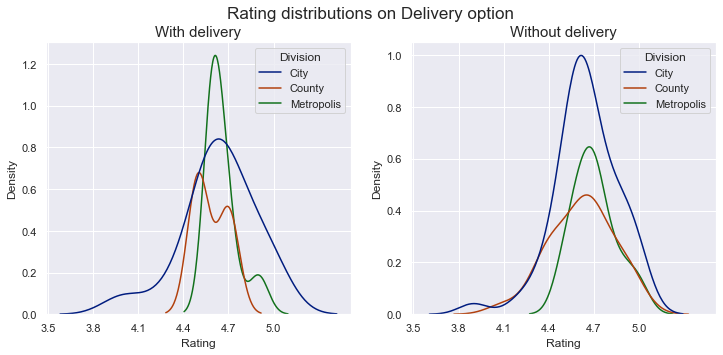

In [36]:
# look at Ratings
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
sns.kdeplot(data=shops[shops['Delivery option'] == True], 
            x='Rating', hue='Division', ax=ax[0])

sns.kdeplot(data=shops[shops['Delivery option'] == False], 
            x='Rating', hue='Division', ax=ax[1])

# set titles
fig.suptitle('Rating distributions on Delivery option', fontsize=17)
ax[0].set_title('With delivery', fontsize=15)
ax[1].set_title('Without delivery', fontsize=15)

# set ticks 
plt.xticks(np.arange(3.5, 5.1, 0.3))
plt.show()

In [37]:
# have a textual representation of ratings

shops.groupby(['Division', 'Delivery option'])['Rating'].mean()

Division    Delivery option
City        False              4.646939
            True               4.635294
            Unknown            4.626667
County      False              4.618519
            True               4.585714
            Unknown            4.850000
Metropolis  False              4.704167
            True               4.655556
            Unknown            4.744444
Name: Rating, dtype: float64

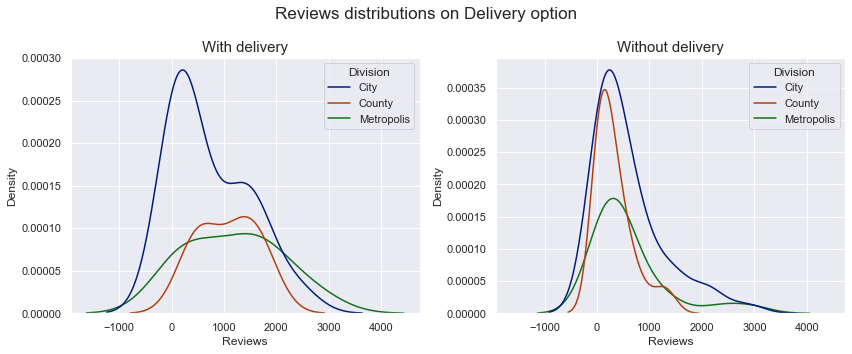

In [38]:
# look at Reviews
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
sns.kdeplot(data=shops[shops['Delivery option'] == True], 
            x='Reviews', hue='Division', ax=ax[0])

sns.kdeplot(data=shops[shops['Delivery option'] == False], 
            x='Reviews', hue='Division', ax=ax[1])

# set titles
fig.suptitle('Reviews distributions on Delivery option', fontsize=17)
ax[0].set_title('With delivery', fontsize=15)
ax[1].set_title('Without delivery', fontsize=15)

plt.tight_layout()
plt.show()

In [40]:
shops.groupby(['Division', 'Delivery option'])['Reviews'].mean()

Division    Delivery option
City        False               596.448980
            True                732.411765
            Unknown             350.878788
County      False               330.851852
            True               1064.714286
            Unknown             279.833333
Metropolis  False               595.041667
            True               1180.888889
            Unknown             359.703704
Name: Reviews, dtype: float64

#### 💡 Insight

**Almost no delivery** <br>
There is a very small number of businesses that offer delivery services. Looking at rating/reviews distributions has revealed that shops **with** delivery option have much more reviews. Each division has almost 2-3 times more reviews if delivery is enabled.  



---

### Model Selection <a class="anchor" id="eval"/>

---

Since the goal is to get the closest segments, unsupervised learning is the best solution to go with. There are two models employed: K-Means and K-Prototypes to handle different types of data. To finish up, the clusters are visualized using T-SNE. This tool lets us visualize high-dimensional datasets. 

**Difference between K-Means & K-Prototypes**
It's a good question to ask about their differences. Both accomplish the same task to find clusters based on data similarity. The difference lies in their instantiations. K-Means tolerates only numeric values. It cannot work with categories. Since our dataset is highly categorical, it would be a waste of data not to include them. K-Prototype address the exact issue, it takes both categorical and numeric values to make decisions. 

### K-Means

In [41]:
# prepare the dataset 
scaler = StandardScaler()

# create a copy of a dataset to not mess with data
cleaned = shops.copy()
cleaned['scaled_rating'] = scaler.fit_transform(cleaned[['Rating']])
cleaned['scaled_reviews'] = scaler.fit_transform(cleaned[['Reviews']])

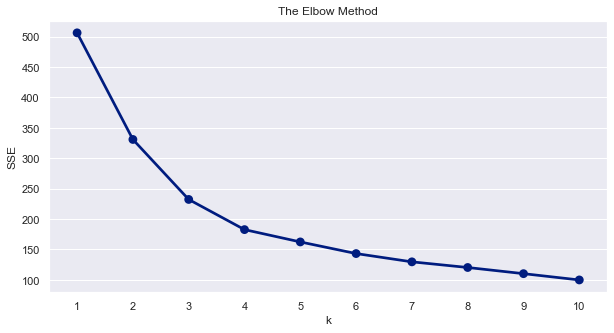

In [42]:
# select numeric features
data = cleaned[['scaled_rating', 'scaled_reviews', 'Dine in option', 'Delivery option']]

# encode categorical columns
data = pd.get_dummies(data, drop_first=True)

#find the elbow to determine the optimal number of clusters
sse={}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data)
    
    # calculate error
    sse[k] = kmeans.inertia_

# visalize error rate vs number of clusters
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

# set title & label axis
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

Using the "Elbow method", we see that the best fit occurs when k=3 or k=4. For easier interpretation, I decided to go with k=3

In [43]:
kmeans = KMeans(3, random_state=1).fit(data)
cleaned['cluster'] = kmeans.labels_

In [44]:
mode = lambda x: x.mode()

cleaned.groupby('cluster').agg({'Rating': [np.min, np.max, np.mean],
                              'Reviews': [np.min, np.max, np.mean], 
                              'Delivery option': mode,
                              'Dine in option': mode,
                              'Place type': 'count'})

Rating                Reviews                      Delivery option  \
          amin amax      mean    amin    amax         mean        <lambda>   
cluster                                                                      
0         3.90  4.7  4.533684     3.0  1009.0   372.905263           False   
1         4.68  5.0  4.886471    10.0   858.0   116.779412         Unknown   
2         4.00  4.9  4.583333   998.0  2931.0  1738.194444            True   

        Dine in option Place type  
              <lambda>      count  
cluster                            
0                 True         95  
1                 True         68  
2                 True         36

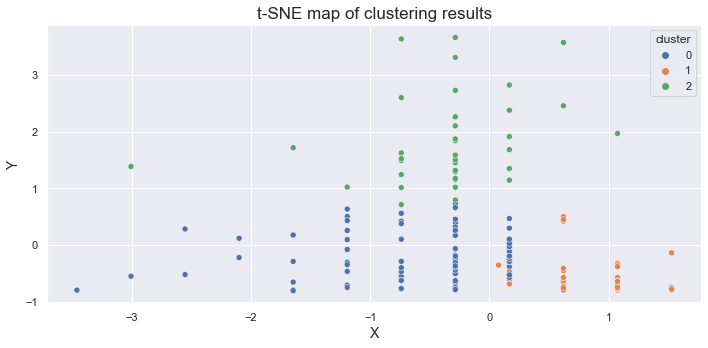

In [45]:
def tsne_map(features, l_rate=100):
    """Create and plot tsne map based on the created matrix"""
    tsne_output = TSNE(learning_rate=l_rate).fit_transform(features.drop('cluster', axis=1))
    tsne_df = pd.DataFrame(index=features.index)
    tsne_df['x'] = tsne_output[:, 0]
    tsne_df['y'] = tsne_output[:, 1]

    # visualize the t-sne representation
    sns.scatterplot(data=features, x='scaled_rating', 
                    y='scaled_reviews', palette='deep',
                    hue='cluster')
    
    plt.title('t-SNE map of clustering results', fontsize=17)
    plt.xlabel('X', fontsize=14); plt.ylabel('Y', fontsize=14)
    plt.tight_layout()
    plt.show()
    

# visalize T-SNE distribution
tsne_map(cleaned[['scaled_rating', 'scaled_reviews', 'cluster']])

### K-Prototype


In [46]:
# re-instantiate a new copy
cleaned = shops.copy()
cleaned.drop('Division', axis='columns', inplace=True)

# get the position of categorical columns
catColumnsPos = [cleaned.columns.get_loc(col) for col in list(cleaned.select_dtypes('category').columns)]

# show categorical columns & indices
print('Categorical columns           : {}'.format(list(cleaned.select_dtypes('category').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Region', 'Place name', 'Place type', 'Price', 'Delivery option', 'Dine in option']
Categorical columns position  : [0, 1, 2, 5, 6, 7]


In [47]:
# change category types
cleaned[['Delivery option', 'Dine in option']] = shops[['Delivery option', 'Dine in option']].astype('bool')

In [48]:
# create individual scalers
rating_scaler = StandardScaler().fit(cleaned[['Rating']])
reviews_scaler = StandardScaler().fit(cleaned[['Reviews']])

# standardize the data
cleaned['Rating'] = rating_scaler.transform(cleaned[['Rating']])
cleaned['Reviews'] = reviews_scaler.transform(cleaned[['Reviews']])

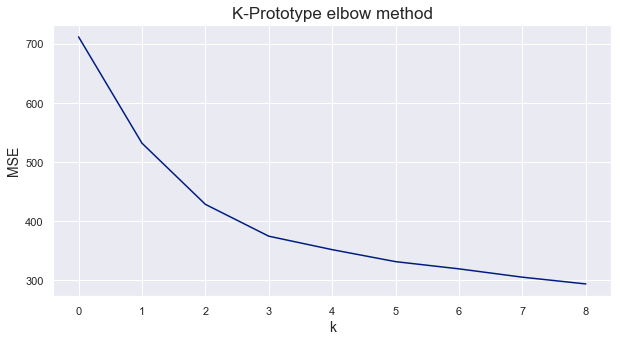

In [49]:
# create empty lists to store error rates
cost = []
dfMatrix = cleaned.to_numpy()

# try out different K values
for cluster in range(1, 10):
    kprototype = KPrototypes(n_jobs=-1, n_clusters=cluster, init='Huang', random_state=42)
    kprototype.fit_predict(dfMatrix, categorical=catColumnsPos)
    
    # calculate and append the cost
    cost.append(kprototype.cost_)

        
# convert the results into a dataframe
df_cost = pd.DataFrame({'Cluster': range(len(cost)), 'Cost':cost})

# plot results
plt.plot(range(len(cost)), cost)

# set labels
plt.xlabel('k', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.title('K-Prototype elbow method', fontsize=17)
plt.show()

In [50]:
# create a model with k=3
k_ptype = KPrototypes(n_jobs=-1, n_clusters=2, init='Huang', random_state=42)

# get the divisions
cleaned['cluster'] = k_ptype.fit_predict(dfMatrix, categorical=catColumnsPos)

# show the new divisions distribution
cleaned['cluster'].value_counts()

1    136
0     63
Name: cluster, dtype: int64

In [51]:
# put normalized values back to original 
cleaned['Reviews'] = reviews_scaler.inverse_transform(cleaned['Reviews'])
cleaned['Rating'] = rating_scaler.inverse_transform(cleaned['Rating'])

# show the final results
cleaned.groupby('cluster').agg({'Rating': [np.min, np.max, np.mean],
                                'Reviews': [np.min, np.max, np.mean], 
                                'Delivery option': mode,
                                'Dine in option': mode,
                                'Place type': [mode, 'count']})

Rating                Reviews                      Delivery option  \
          amin amax      mean    amin    amax         mean        <lambda>   
cluster                                                                      
0          3.9  4.9  4.485714     3.0  2931.0  1241.603175            True   
1          4.3  5.0  4.745441    10.0   858.0   203.830882           False   

        Dine in option   Place type        
              <lambda>   <lambda_0> count  
cluster                                    
0                 True  Coffee shop    63  
1                 True  Coffee shop   136

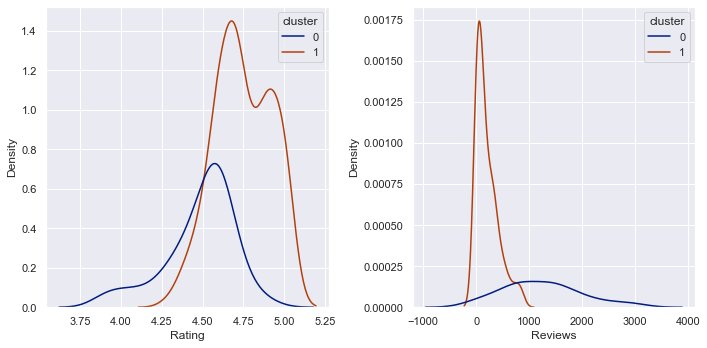

In [52]:
fig, ax = plt.subplots(1, 2)
sns.kdeplot(data=cleaned, x='Rating', hue='cluster', ax=ax[0], palette='dark')
sns.kdeplot(data=cleaned, x='Reviews', hue='cluster', ax=ax[1], palette='dark')
plt.tight_layout()
plt.show()

---

### Results <a class="anchor" id="results"/>

---


##### K-Means

This method suggested dividing the data into 3-4 clusters. I decided to go with 3 clusters since they give a good data divsion. 

| Group | Rating | Review | Delivery | Dine-in & Takeout | # of shops |
| --- | --- | --- | --- | --- | --- |
| 0 | Low-Average (3.9-4.7) | Average (avg=372) | No | Yes | 95 |
| 1 | High (4.7-5) | Low (avg=116) | Uknown | Yes | 68 |
| 2 | Medium-High (4.0-4.9) | High (avg=1738) | True | Yes | 36 |

**Interpretation**: There are three main segments the business market can be divided into. The first group represents shops that don't have a delivery option. Those are the places where people come to relax and feel like at home. Maybe they're the ones where we can go for our next coffee-dates? These places have an OK rating and reviews, and they make up the majority of our dataset. 

The second cluster represent places with the best service based on their reviews. Even though there's not a big number of reviews, they're know how to serve customers. The only problem is that there was a big number of missing values in delivery option. Therefore, it's hard to say what other options the businesses provide. 

The last cluster represents a busy lifestyle of the people in big cities. We need our coffe, and we need it now! This cluster has all the services available. It's not surprising that they have the biggest number of reviews, huh? 


##### K-Prototypes

This method suggested diving the data into 2 clusters:

| Group | Rating | Review | Delivery | Dine-in & Takeout | # of shops |
| --- | --- | --- | --- | --- | --- |
| 0 | Low-High | High (avg=1242) | Yes | Yes | 63 |
| 1 | Medium-High (4.3-5) | Low (avg=203) | False | Yes | 136 |

Essentially, both K-Means and K-Prototypes suggest taking shops with and without delivery options. The model implies that there's a big distinction between these group. It's true and it was found during the Exploratory Data Analysis step in [Question 3](#q3). 

--- 

### Final recommendations <a class="anchor" id="recommend"/>

---

- Know your region

We saw previously in [Question 1](#q1) and [Question 2](#q2) that the regions have pretty unique trends. The biggest and smallest cities appreciate coffee shops, whereas medium ones like to sit-in and relax in an establishment. The biggest cities also provide a bigger number of #extravagant places like espresso bars. 

- Enable delivery

[Question 3](#q3) has revealed that places with delivery options have much bigger number of reviews. Therefore, it's safe to assume that more people order in such places. It makes sense, we don't always have the opportunity to go to a place and wait in line. Therefore, when considering to open a business, it's a good idea to have this option. 

- Gather more data

It's hard to make definite recommendations with only 200 data entries. Therefore, to make a more reliable analysis, we need to obtain a lot of data. 


#### References

[1] Ridder, M. (2022, February 23). *Coffee consumption worldwide from 2012/13 to 2020/21*. Statista. Available: <a href="https://www.statista.com/statistics/292595/global-coffee-consumption/#:~:text=Global%20coffee%20consumption%202012%2F13%2D2020%2F21&text=In%202020%2F2021%2C%20around%20166.63,bags%20in%20the%20previous%20year">here</a> <br>
[2] Huang, Z. (1998). Extensions to the k-means algorithm for clustering large data sets with categorical values. *Data mining and knowledge discovery*, 2(3), 283-304.